# Testing of Temperature REMD

## Setup

In [20]:
using Pkg
Pkg.activate("../../")

  Activating project at `d:\Projects\OpenSource\ReplicaExchangeMD.jl`

In [21]:
using ReplicaExchangeMD

In [ ]:
using Plots

In [ ]:
Threads.nthreads()

In [ ]:
using BenchmarkTools

## System Parameters

In [5]:
n_atoms = 100
atom_mass = 10.0u"u"
atoms = [Atom(mass=atom_mass, σ=0.3u"nm", ϵ=0.2u"kJ * mol^-1") for i in 1:n_atoms];

LoadError: LoadError: UndefVarError: @u_str not defined
in expression starting at d:\Projects\OpenSource\ReplicaExchangeMD.jl\test\notebooks\simulator_test.ipynb:2

In [6]:
boundary = CubicBoundary(2.0u"nm", 2.0u"nm", 2.0u"nm")
coords = place_atoms(n_atoms, boundary, 0.3u"nm"); # Random placement without clashing

LoadError: LoadError: UndefVarError: @u_str not defined
in expression starting at d:\Projects\OpenSource\ReplicaExchangeMD.jl\test\notebooks\simulator_test.ipynb:1

In [7]:
temp = 100.0u"K"
velocities = [velocity(atom_mass, temp) for i in 1:n_atoms];

LoadError: LoadError: UndefVarError: @u_str not defined
in expression starting at d:\Projects\OpenSource\ReplicaExchangeMD.jl\test\notebooks\simulator_test.ipynb:1

In [8]:
pairwise_inters = (LennardJones(),) # Don't forget the trailing comma!

UndefVarError: UndefVarError: LennardJones not defined

In [9]:
nb_matrix = trues(n_atoms, n_atoms)
for i in 1:(n_atoms ÷ 2)
    nb_matrix[i, i + (n_atoms ÷ 2)] = false
    nb_matrix[i + (n_atoms ÷ 2), i] = false
end

neighbor_finder = DistanceNeighborFinder(
    nb_matrix=nb_matrix,
    n_steps=10,
    dist_cutoff=1.5u"nm",
)

LoadError: LoadError: UndefVarError: @u_str not defined
in expression starting at d:\Projects\OpenSource\ReplicaExchangeMD.jl\test\notebooks\simulator_test.ipynb:10

## Test Simulation for normal system

In [10]:
sys = System(
    atoms=atoms,
    pairwise_inters=pairwise_inters,
    coords=coords,
    velocities=velocities,
    boundary=boundary,
    loggers=(
        temp=TemperatureLogger(10),
        coords=CoordinateLogger(10),
    ),
    neighbor_finder=neighbor_finder,
)

UndefVarError: UndefVarError: TemperatureLogger not defined

In [11]:
simulator = Langevin(
    dt=0.005u"ps",
    temperature=temp,
    friction=0.1u"ps^-1",
);

LoadError: LoadError: UndefVarError: @u_str not defined
in expression starting at d:\Projects\OpenSource\ReplicaExchangeMD.jl\test\notebooks\simulator_test.ipynb:2

In [12]:
@time Molly.simulate!(sys, simulator, 20_000; n_threads=2)

UndefVarError: UndefVarError: Molly not defined

In [13]:
length(values(sys.loggers.temp))

UndefVarError: UndefVarError: sys not defined

In [14]:
plot(ustrip.(values(sys.loggers.temp)), size=(1200, 400))

UndefVarError: UndefVarError: sys not defined

In [15]:
scatter([ustrip(c[50][1]) for c in values(sys.loggers.coords)], size=(1200, 400))
scatter!([ustrip(c[50][2]) for c in values(sys.loggers.coords)])
scatter!([ustrip(c[50][3]) for c in values(sys.loggers.coords)])

UndefVarError: UndefVarError: sys not defined

# Test simulation for replica system

In [16]:
n_replicas = 4
repsys = ReplicaSystem(
    atoms=atoms,
    coords=coords,
    replica_velocities=nothing,
    n_replicas=n_replicas,
    boundary=boundary,
    pairwise_inters=pairwise_inters,
    replica_loggers=Tuple((temp=TemperatureLogger(10), coords=CoordinateLogger(10)) for i in 1:n_replicas),
    neighbor_finder=neighbor_finder,
)

UndefVarError: UndefVarError: TemperatureLogger not defined

In [17]:
temp_vals = [120.0u"K", 180.0u"K", 240.0u"K", 300.0u"K"]
simulator = TemperatureREMD(
    dt=0.005u"ps",
    temperatures=temp_vals,
    simulators=[
        Langevin(
            dt=0.005u"ps",
            temperature=tmp,
            friction=0.1u"ps^-1",
        )
        for tmp in temp_vals],
    exchange_time=2.5u"ps",
);

LoadError: LoadError: UndefVarError: @u_str not defined
in expression starting at d:\Projects\OpenSource\ReplicaExchangeMD.jl\test\notebooks\simulator_test.ipynb:1

In [80]:
convert(Int64, (20_000 * simulator.dt) ÷ simulator.exchange_time)

40

In [74]:
@time simulate!(repsys, simulator, 20_000; assign_velocities=true);

 13.159510 seconds (4.02 M allocations: 7.138 GiB, 20.33% gc time)


In [75]:
[(s, ind) for (s, ind) in zip(repsys.exchange_logger.steps, repsys.exchange_logger.indices)]

25-element Vector{Tuple{Int64, Tuple{Int64, Int64}}}:
 (1500, (2, 3))
 (2000, (3, 4))
 (3000, (1, 2))
 (4000, (3, 4))
 (4500, (2, 3))
 (5000, (3, 4))
 (5500, (2, 3))
 (7000, (3, 4))
 (8000, (3, 4))
 (8500, (2, 3))
 ⋮
 (15000, (3, 4))
 (16000, (3, 4))
 (17000, (1, 2))
 (17500, (2, 3))
 (18000, (1, 2))
 (18000, (3, 4))
 (18500, (2, 3))
 (19000, (3, 4))
 (19500, (2, 3))

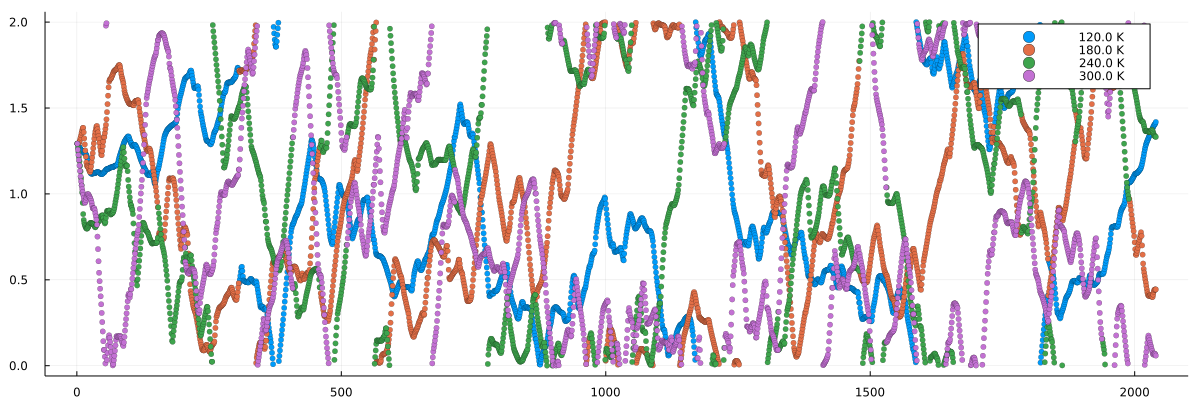

In [76]:
s = scatter([ustrip(c[10][1]) for c in values(repsys.replicas[1].loggers.coords)], label=temp_vals[1], markersize=3.0, markerstrokewidth=0.2, size=(1200, 400))
for repidx=2:n_replicas
    scatter!([ustrip(c[10][1]) for c in values(repsys.replicas[repidx].loggers.coords)], label=temp_vals[repidx], markersize=3.0, markerstrokewidth=0.2)
end
savefig(s, "plots/x_coordiantes_of_atom_10_in_each_replica_v2.png")
s

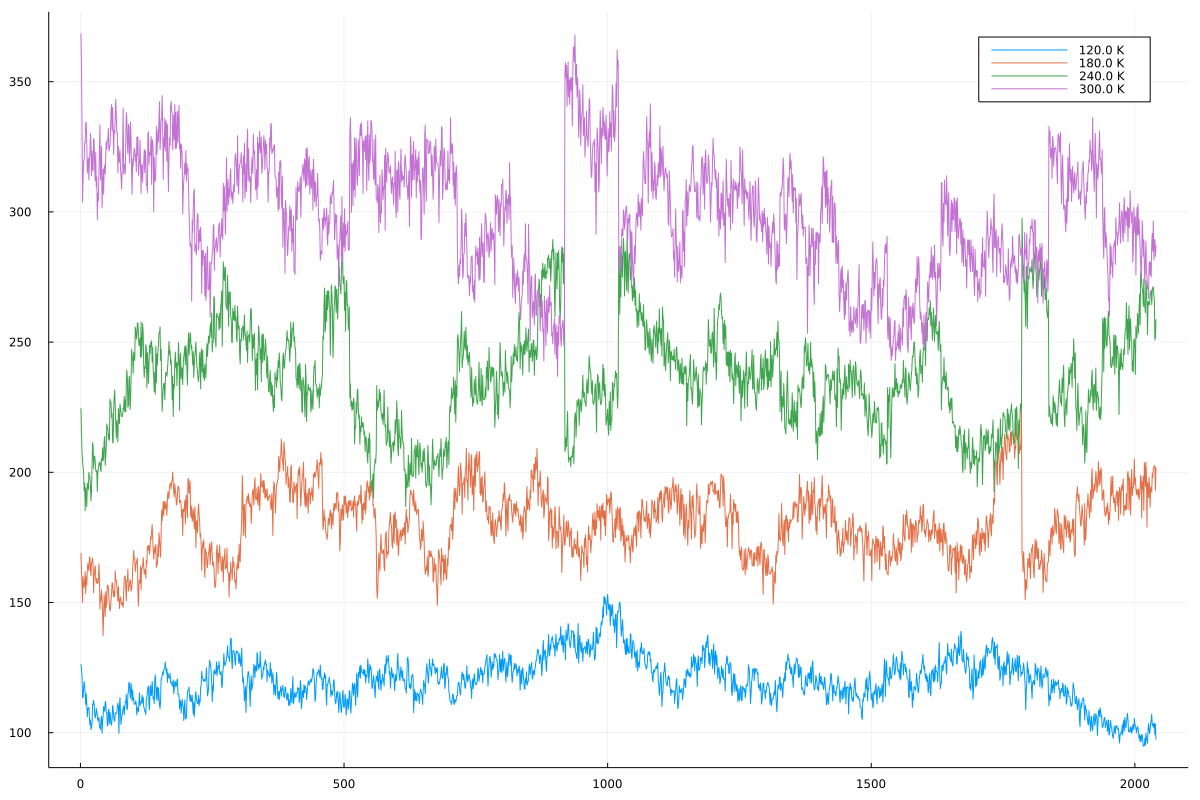

In [77]:
s = plot(ustrip.(values(repsys.replicas[1].loggers.temp)), label=temp_vals[1], linestyle=:solid, size=(1200, 800))
for repidx=2:n_replicas
    plot!(ustrip.(values(repsys.replicas[repidx].loggers.temp)), label=temp_vals[repidx], linestyle=:solid)
end
savefig(s, "plots/temperature_of_each_replica_v2.png")
s

In [78]:
using Statistics

for repidx=1:n_replicas
    mean(ustrip.(values(repsys.replicas[repidx].loggers.temp))) |> println
end

120.17146311592558
180.26934699640375
236.51371387000344
299.4797851128037


In [22]:
120.23509253240302
164.6263280509574
198.80467352029018
247.31690097893383